In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timezone
from scipy.stats import skew, kurtosis
from scipy.fftpack import fft
import os
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix as cm

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')

In [2]:
# persons = [ 'P' + f"{num:02}" for num in range(1,18)]
# persons

In [3]:
# Get a list of all files in the folder
files = os.listdir("EARBUDS_Labels/Good")

# Extract the first three letters of the file names and create a list
persons = []

for file in files:
    if(file[0] == 'P'):
        persons.append(file[:3])

In [4]:
persons

['P09', 'P10', 'P07', 'P13', 'P17', 'P01', 'P05', 'P06', 'P11', 'P08']

# Extracting Features

In [10]:
def extract_features(data, isfft):
    features = []
    for axis in ['ax', 'ay', 'az', 'gx', 'gy', 'gz']:
        features.append(np.mean(data[axis]))
        features.append(np.std(data[axis]))
        features.append(np.mean(np.abs(data[axis] - np.mean(data[axis]))))
        features.append(np.min(data[axis]))
        features.append(np.max(data[axis]))
        features.append(np.max(data[axis]) - np.min(data[axis]))
        features.append(np.median(data[axis]))
        features.append(np.median(np.abs(data[axis] - np.median(data[axis]))))
        Q1 = np.percentile(data[axis], 25)
        Q3 = np.percentile(data[axis], 75)
        features.append(Q3 - Q1)
        
        if(isfft == False):
            features.append(np.sum(data[axis] < 0))
            features.append(np.sum(data[axis] > 0))
            
        features.append(np.sum(data[axis] > np.mean(data[axis])))
        diff = np.diff(np.sign(np.diff(data[axis])))
        peaks = np.where(diff == 2)[0] + 1
        features.append(len(peaks))
        features.append(skew(data[axis]))
        features.append(kurtosis(data[axis]))
        features.append(np.mean(data[axis]**2))
        
        argmin = data[axis].idxmin()
        argmax = data[axis].idxmax()
        diff_argmax_argmin = argmax - argmin
        
        features.append(argmax)
        features.append(argmin)
        features.append(diff_argmax_argmin)
        
    
     # Aggregate 'energy' and 'average resultant acceleration' for all three axes
    avg_resultant_acceleration = np.mean([np.sqrt(np.mean(data[axis]**2)) for axis in ['ax', 'ay', 'az']])
    signal_magnitude_area = np.mean([np.sum(np.abs(data[axis])) for axis in ['ax', 'ay', 'az']])
    avg_resultant_acceleration_g = np.mean([np.sqrt(np.mean(data[axis]**2)) for axis in ['gx', 'gy', 'gz']])
    signal_magnitude_area_g = np.mean([np.sum(np.abs(data[axis])) for axis in ['gx', 'gy', 'gz']])
    
    features.append(avg_resultant_acceleration)
    features.append(signal_magnitude_area)
    features.append(avg_resultant_acceleration_g)
    features.append(signal_magnitude_area_g)

    return features

# Define a function to compute FFT for a column
def compute_fft(column):
    fft_result = fft(column)
    return np.abs(pd.Series(fft_result))[:250]
                        
def windows():
    Train = pd.DataFrame()
    Test = pd.DataFrame()
    
    for pn,person in enumerate(persons):
        df = pd.read_csv(f"EARBUDS_Labels/Good/{person}-imu-right.csv")
        df = df[['ax', 'ay', 'az', 'gx', 'gy', 'gz','Label']]
        window_size = 500
        overlap = int(window_size * 0.5)
        windows = [df[i:i+window_size] for i in range(0, len(df) - window_size + 1, overlap)]
        
        feature_columns = []  # List to hold the feature column names

        # Initialize a DataFrame to store the features
        feature_df = pd.DataFrame()

        # Find the number of windows that can be created
        num_windows = len(df) // overlap - 1

        for i in range(num_windows):
            window = windows[i]

            if len(window) < window_size:
                continue  # Skip incomplete windows

            # Find the most common label in this window
            most_common_label = window['Label'].mode().values[0]

            # Extract features for each window
            window_features = extract_features(window, False)

            # Append the label with the highest frequency in this window
            window_features.append(most_common_label)

            feature_df = feature_df.append(pd.Series(window_features), ignore_index=True)

        # Rename the columns for the 50 features
        for axis in ['ax', 'ay', 'az', 'gx', 'gy', 'gz']:
            for stat in ['mean', 'std', 'absdev', 'min', 'max', 'maxmin', 'median', 'medianabsdev', 'iqr', 'negcount', 'poscount', 'abovemean', 'peakcount', 'skew', 'kurtosis', 'energy','argmax','argmin','arg_diff']:
                feature_columns.append(f'{axis}_{stat}')
        
        feature_columns.append('avg_result_accl')
        feature_columns.append('sma')
        feature_columns.append('avg_result_gyro')
        feature_columns.append('sma_g')
        # Add label column name
        feature_columns.append('label')

        feature_df.columns = feature_columns
        
        # Initialize a new list to store DataFrames
        fft_windows = []
        # Iterate through the original DataFrames
        for w in windows:
            # Create a new DataFrame with the FFT of the first 250 values of 'ax', 'ay', 'az'
            fft_df = pd.DataFrame()
            fft_df['ax'] = compute_fft(w['ax'].values)
            fft_df['ay'] = compute_fft(w['ay'].values)
            fft_df['az'] = compute_fft(w['az'].values)
            fft_df['gx'] = compute_fft(w['gx'].values)
            fft_df['gy'] = compute_fft(w['gy'].values)
            fft_df['gz'] = compute_fft(w['gz'].values)
            
            fft_df['Label'] = pd.Series(w['Label'].values[:250]) # Keep the original labels
            
            # Append the new DataFrame to the list
            fft_windows.append(fft_df)
        
        fft_feature_columns = []  # List to hold the feature column names

        # Initialize a DataFrame to store the features
        fft_feature_df = pd.DataFrame()

        # Find the number of windows that can be created
        num_windows = len(fft_windows)

        for i in range(num_windows):
            window = fft_windows[i]

            if len(window) < window_size*0.5:
                continue  # Skip incomplete windows

            # Extract features for each window
            window_features = extract_features(window, True)

            fft_feature_df = fft_feature_df.append(pd.Series(window_features), ignore_index=True)

        # Rename the columns for the 50 features
        for axis in ['ax', 'ay', 'az', 'gx', 'gy', 'gz']:
            for stat in ['mean', 'std', 'absdev', 'min', 'max', 'maxmin', 'median', 'medianabsdev', 'iqr', 'abovemean', 'peakcount', 'skew', 'kurtosis', 'energy','argmax','argmin','arg_diff']:
                fft_feature_columns.append(f'fft_{axis}_{stat}')
        
        fft_feature_columns.append('fft_avg_result_accl')
        fft_feature_columns.append('fft_sma')
        fft_feature_columns.append('fft_avg_result_gyro')
        fft_feature_columns.append('fft_sma_g')
        
        fft_feature_df.columns = fft_feature_columns
        
        stacked_df = pd.concat([fft_feature_df, feature_df], axis=1)
        
        stacked_df['user'] = person
        
        if(pn <= 7):
            Train = pd.concat([Train, stacked_df], axis=0)
        else:
            Test = pd.concat([Test, stacked_df], axis=0)
    
    return Train, Test
                        

In [11]:
Train, Test = windows()

In [12]:
Train

,fft_ax_mean,fft_ax_std,fft_ax_absdev,fft_ax_min,fft_ax_max,fft_ax_maxmin,fft_ax_median,fft_ax_medianabsdev,fft_ax_iqr,fft_ax_abovemean,...,gz_energy,gz_argmax,gz_argmin,gz_arg_diff,avg_result_accl,sma,avg_result_gyro,sma_g,label,user
0,7127.506640,106181.742617,13408.167592,5.096300,1682603.0,1.682598e+06,213.832493,105.237752,241.637030,2.0,...,1577.850,13.0,468.0,-455.0,8173.053706,4.086462e+06,33.357037,13245.333333,1.0,P09
1,7150.011195,106991.407803,13581.540534,10.652314,1695350.0,1.695339e+06,178.935092,80.558797,205.060889,2.0,...,1425.862,495.0,697.0,-202.0,8169.929477,4.084862e+06,31.607146,12881.666667,1.0,P09
2,7177.165886,107654.168335,13606.142048,7.330324,1705881.0,1.705874e+06,175.842377,72.933297,174.208063,2.0,...,1465.406,500.0,850.0,-350.0,8168.619362,4.084250e+06,32.688713,13335.333333,1.0,P09
3,7417.835038,107072.521965,13516.417320,111.992396,1696970.0,1.696858e+06,536.776560,104.761184,221.686200,1.0,...,1338.652,1150.0,850.0,300.0,8157.974422,4.078421e+06,34.901214,13264.000000,1.0,P09
4,7422.805523,107499.351154,13570.353556,134.984355,1703717.0,1.703582e+06,534.765911,119.883948,236.054537,1.0,...,971.094,1150.0,1161.0,-11.0,8158.545666,4.078721e+06,31.655618,11725.666667,1.0,P09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905,12179.719237,83998.167099,16876.054055,239.020600,1300511.0,1.300272e+06,2102.470887,910.675801,3019.364130,28.0,...,656688.266,226352.0,226390.0,-38.0,7748.524715,3.768647e+06,819.360480,302002.333333,6.0,P06
906,10232.070244,84521.706118,13589.839897,180.328183,1334856.0,1.334676e+06,2656.812813,1351.378340,2871.958204,17.0,...,408165.382,226941.0,226885.0,56.0,7359.544220,3.657537e+06,617.455067,214363.666667,6.0,P06
907,9402.838467,78966.541450,12658.789849,152.761394,1245332.0,1.245179e+06,2159.506860,954.630401,2428.772655,20.0,...,338443.660,226941.0,226885.0,56.0,7462.869496,3.718418e+06,462.389871,140712.333333,6.0,P06
908,9134.108736,90383.967218,14535.710293,106.714798,1421526.0,1.421419e+06,972.372770,385.188864,929.889283,18.0,...,46503.138,227214.0,227088.0,126.0,7565.576537,3.770215e+06,220.504260,86922.666667,6.0,P06


In [13]:
Test

,fft_ax_mean,fft_ax_std,fft_ax_absdev,fft_ax_min,fft_ax_max,fft_ax_maxmin,fft_ax_median,fft_ax_medianabsdev,fft_ax_iqr,fft_ax_abovemean,...,gz_energy,gz_argmax,gz_argmin,gz_arg_diff,avg_result_accl,sma,avg_result_gyro,sma_g,label,user
0,6153.627921,18428.646282,7710.302253,43.520915,162088.0,162044.479085,1196.033553,814.314791,3596.666159,48.0,...,268828.990,486.0,110.0,376.0,7936.498026,3.909412e+06,642.202735,207301.333333,1.0,P11
1,6852.179843,21259.357879,8424.472188,22.248231,241896.0,241873.751769,1424.135075,987.771492,4077.606217,49.0,...,491027.668,656.0,557.0,99.0,7989.555404,3.952781e+06,579.689294,219393.666667,1.0,P11
2,6244.042754,23167.885673,7897.042346,51.585831,307750.0,307698.414169,1165.053617,833.086660,3531.550189,43.0,...,413405.804,656.0,557.0,99.0,7999.524718,3.959330e+06,527.176378,191711.000000,1.0,P11
3,5707.752516,28391.425048,7459.874208,106.048022,406555.0,406448.951978,1084.006534,590.453012,1909.651592,36.0,...,158585.800,1007.0,1212.0,-205.0,8035.208081,3.981308e+06,370.366722,133682.333333,1.0,P11
4,4878.690721,36774.719460,6919.982632,1.301984,577295.0,577293.698016,529.817956,335.662779,1398.800335,37.0,...,135924.420,1007.0,1212.0,-205.0,8049.701164,4.013394e+06,322.884392,95799.333333,1.0,P11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
816,4097.130734,60180.031553,7596.958954,26.439620,953717.0,953690.560380,225.560052,99.660157,246.086630,1.0,...,426.172,204252.0,204248.0,4.0,7747.526623,3.873743e+06,28.869892,10967.666667,6.0,P08
817,4088.205012,60240.861457,7604.646360,1.561350,954669.0,954667.438650,232.424989,100.164945,212.576786,1.0,...,392.224,204252.0,204256.0,-4.0,7752.422373,3.876200e+06,25.829204,10252.000000,6.0,P08
818,5662.292228,60011.526501,7574.037662,76.169706,952417.0,952340.830294,1446.669889,671.777221,1759.813267,1.0,...,19265.646,204990.0,204982.0,8.0,7747.406416,3.872755e+06,291.777032,35747.666667,6.0,P08
819,5703.082117,58408.636691,7481.174296,117.966267,926962.0,926844.033733,1360.362117,742.597563,2067.854893,10.0,...,24183.182,204990.0,204982.0,8.0,7627.502705,3.807875e+06,331.895243,57327.333333,6.0,P08


# ML Models

In [18]:
X_train = Train.iloc[:,:-2].values
y_train = Train.iloc[:,-2].values

In [19]:
X_test = Test.iloc[:,:-2].values
y_test = Test.iloc[:,-2].values

In [20]:
# standardization
scaler = StandardScaler()
scaler.fit(X_train)
X_train_data_lr = scaler.transform(X_train)
X_test_data_lr = scaler.transform(X_test)

## Logistic Regreesion

In [21]:
# logistic regression model
lr = LogisticRegression()
lr.fit(X_train_data_lr, y_train)
y_pred = lr.predict(X_test_data_lr)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.5650406504065041

 -------------Classification Report-------------

              precision    recall  f1-score   support

         1.0       0.67      0.46      0.54       227
         2.0       0.47      0.38      0.42       336
         3.0       0.37      0.65      0.47       269
         4.0       0.48      0.45      0.46       258
         5.0       0.88      0.39      0.54       275
         6.0       0.74      0.96      0.84       357

    accuracy                           0.57      1722
   macro avg       0.60      0.55      0.55      1722
weighted avg       0.60      0.57      0.56      1722



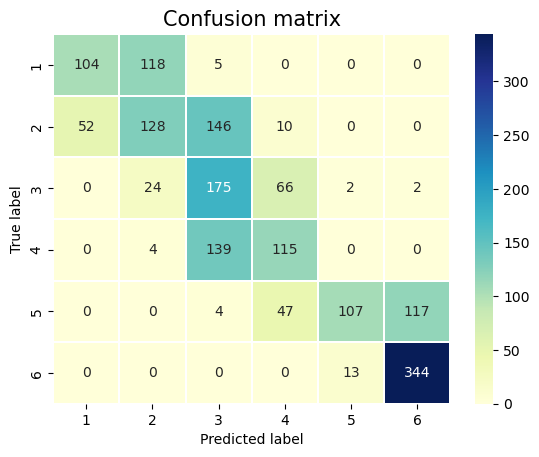

In [22]:
labels = [1,2,3,4,5,6]
confusion_matrix = cm(y_test, y_pred)
sns.heatmap(confusion_matrix, xticklabels=labels, yticklabels=labels, annot=True,linewidths = 0.1, fmt="d", cmap = 'YlGnBu')
plt.title("Confusion matrix", fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Decision Tree

In [23]:
# Decision Tree Classifier model
lr = DecisionTreeClassifier()
lr.fit(X_train_data_lr, y_train)
y_pred = lr.predict(X_test_data_lr)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.6980255516840883

 -------------Classification Report-------------

              precision    recall  f1-score   support

         1.0       0.88      0.50      0.64       227
         2.0       0.62      0.86      0.72       336
         3.0       0.75      0.64      0.69       269
         4.0       0.59      0.73      0.66       258
         5.0       0.67      0.59      0.63       275
         6.0       0.81      0.77      0.79       357

    accuracy                           0.70      1722
   macro avg       0.72      0.68      0.69      1722
weighted avg       0.72      0.70      0.70      1722



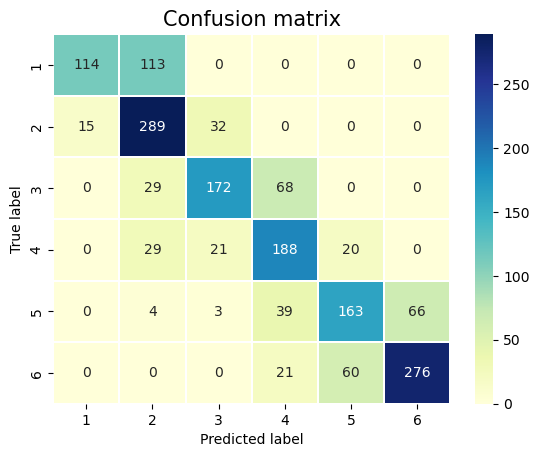

In [24]:
labels = [1,2,3,4,5,6]
confusion_matrix = cm(y_test, y_pred)
sns.heatmap(confusion_matrix, xticklabels=labels, yticklabels=labels, annot=True,linewidths = 0.1, fmt="d", cmap = 'YlGnBu')
plt.title("Confusion matrix", fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### Hyperparameter tuning in Decision Tree

## Random Forest

In [25]:
# Random forest Classifier model
lr = RandomForestClassifier()
lr.fit(X_train_data_lr, y_train)
y_pred = lr.predict(X_test_data_lr)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.7909407665505227

 -------------Classification Report-------------

              precision    recall  f1-score   support

         1.0       0.97      0.65      0.78       227
         2.0       0.70      0.94      0.80       336
         3.0       0.81      0.70      0.75       269
         4.0       0.83      0.79      0.81       258
         5.0       0.76      0.67      0.71       275
         6.0       0.82      0.90      0.86       357

    accuracy                           0.79      1722
   macro avg       0.81      0.78      0.78      1722
weighted avg       0.80      0.79      0.79      1722



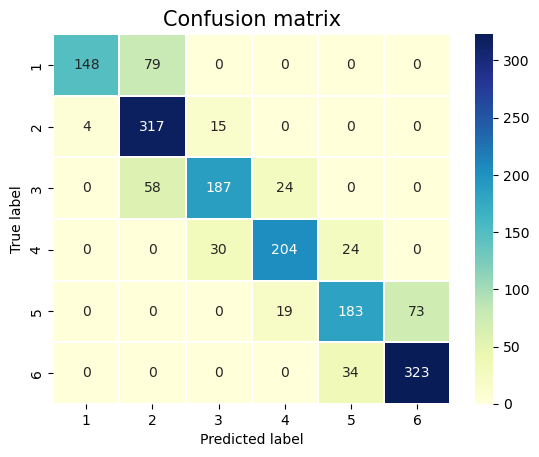

In [26]:
labels = [1,2,3,4,5,6]
confusion_matrix = cm(y_test, y_pred)
sns.heatmap(confusion_matrix, xticklabels=labels, yticklabels=labels, annot=True,linewidths = 0.1, fmt="d", cmap = 'YlGnBu')
plt.title("Confusion matrix", fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### Hyper parameter tuning on Random Forest

## Naive Bayes Classifier

In [27]:
# Gaussian Naive Bayes Classifier model
lr = GaussianNB()
lr.fit(X_train_data_lr, y_train)
y_pred = lr.predict(X_test_data_lr)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.4564459930313589

 -------------Classification Report-------------

              precision    recall  f1-score   support

         1.0       0.55      0.69      0.61       227
         2.0       0.45      0.50      0.47       336
         3.0       0.31      0.46      0.37       269
         4.0       0.17      0.08      0.11       258
         5.0       0.46      0.40      0.43       275
         6.0       0.71      0.58      0.64       357

    accuracy                           0.46      1722
   macro avg       0.44      0.45      0.44      1722
weighted avg       0.45      0.46      0.45      1722



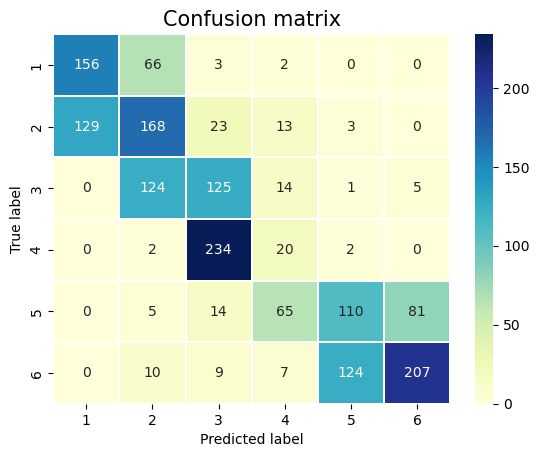

In [28]:
labels = [1,2,3,4,5,6]
confusion_matrix = cm(y_test, y_pred)
sns.heatmap(confusion_matrix, xticklabels=labels, yticklabels=labels, annot=True,linewidths = 0.1, fmt="d", cmap = 'YlGnBu')
plt.title("Confusion matrix", fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### Hyperparameter tuning on Naive Bayes

## Support Vector Classification

In [29]:
# SVC Classifier model
lr = SVC()
lr.fit(X_train_data_lr, y_train)
y_pred = lr.predict(X_test_data_lr)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.5696864111498258

 -------------Classification Report-------------

              precision    recall  f1-score   support

         1.0       0.65      0.42      0.51       227
         2.0       0.44      0.45      0.44       336
         3.0       0.41      0.75      0.53       269
         4.0       0.70      0.42      0.53       258
         5.0       0.94      0.28      0.44       275
         6.0       0.69      0.97      0.80       357

    accuracy                           0.57      1722
   macro avg       0.64      0.55      0.54      1722
weighted avg       0.63      0.57      0.55      1722



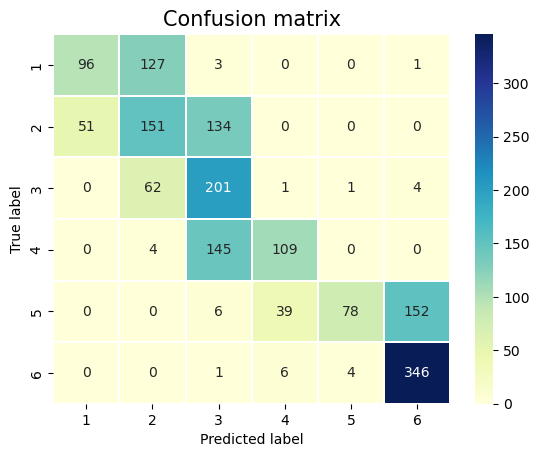

In [30]:
labels = [1,2,3,4,5,6]
confusion_matrix = cm(y_test, y_pred)
sns.heatmap(confusion_matrix, xticklabels=labels, yticklabels=labels, annot=True,linewidths = 0.1, fmt="d", cmap = 'YlGnBu')
plt.title("Confusion matrix", fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### Hyper parameter tuning in SVC

# DL Models